# 0. Downloading dataset

In [1]:
# install kaggle python api
!pip install kaggle --upgrade

In [2]:
import os, json, subprocess

In [3]:
def check_dataset(path=''):
    if not path:
        path = os.getcwd() + '/dataset/'  
    return os.path.exists(path + 'cataract') and os.path.exists(path + 'diabetic_retinopathy') and os.path.exists(path + 'glaucoma') and os.path.exists(path + 'normal')
    
def init_on_kaggle(username, api_key):
    KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
    os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
    api_dict = {"username":username, "key":api_key}
    with open(f"{KAGGLE_CONFIG_DIR}/kaggle.json", "w", encoding='utf-8') as f:
        json.dump(api_dict, f)
    cmd = f"chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json"
    output = subprocess.check_output(cmd.split(" "))
    output = output.decode(encoding='UTF-8')
    print(output)
    
    
def download_dataset_from_kaggle():
    init_on_kaggle("yudzhao", '14e199e96baf549cf5fbf0c5f2dfbc27')
    
    import kaggle
    dataset_name = "gunavenkatdoddi/eye-diseases-classification"
    print(kaggle.api.dataset_view(dataset_name))
    
    kaggle.api.dataset_download_files(dataset_name)
    
    os.system('unzip eye-diseases-classification.zip')
    

In [4]:
dataset_location = os.getcwd() + "/dataset/"

In [5]:
if not check_dataset(dataset_location):
    print('The dataset doesn\'t exist. Try to load from kaggle')
    download_dataset_from_kaggle()

In [6]:
!ls

README.md
dataset
eye-diseases-classification.zip
eye_diseases_classification.ipynb
spark-deep-learning-1.5.0-spark2.4-s_2.11.jar


# 1. Data Preparation

## 1.1 Import Images

In [7]:
!pip install Pillow

In [8]:
!pip install pyspark

  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,length,sum,avg,max,count,round
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
import io

In [10]:
spark = SparkSession.builder\
        .master("local")\
        .appName("eye_diseases_calssification")\
        .config("spark.driver.memory", "8g") \
        .config("spark.jars", "./spark-deep-learning-1.5.0-spark2.4-s_2.11.jar") \
        .getOrCreate()

In [11]:
df = spark.read.format('image').option('dropInvalid', True) \
    .option("recursiveFileLookup","true").load(dataset_location)

In [12]:
label = when(col('image.origin').contains('cataract'), 'cataract')\
.when(col('image.origin').contains('diabetic_retinopathy'), 'diabetic_retinopathy')\
.when(col('image.origin').contains('glaucoma'), 'glaucoma')\
.otherwise('normal')

df = df.withColumn('type', label)

# 2 Discriptive & Visualization

## 2.1 Summary

In [13]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- type: string (nullable = false)



In [14]:
df.count()

2977

In [15]:
df.select('type', 'image.origin', 'image.width', 'image.height', 'image.nChannels', 'image.mode').show(10, truncate=False)

+--------+-----------------------------------------------------------------------------------+-----+------+---------+----+
|type    |origin                                                                             |width|height|nChannels|mode|
+--------+-----------------------------------------------------------------------------------+-----+------+---------+----+
|cataract|file:///Users/zhaoyudong/workspace/clarku/BAN5600/dataset/cataract/cataract_024.png|2464 |1632  |3        |16  |
|glaucoma|file:///Users/zhaoyudong/workspace/clarku/BAN5600/dataset/glaucoma/Glaucoma_081.png|2464 |1632  |3        |16  |
|glaucoma|file:///Users/zhaoyudong/workspace/clarku/BAN5600/dataset/glaucoma/Glaucoma_072.png|2464 |1632  |3        |16  |
|glaucoma|file:///Users/zhaoyudong/workspace/clarku/BAN5600/dataset/glaucoma/Glaucoma_024.png|2464 |1632  |3        |16  |
|glaucoma|file:///Users/zhaoyudong/workspace/clarku/BAN5600/dataset/glaucoma/Glaucoma_071.png|2464 |1632  |3        |16  |
|glaucoma|file:/

In [16]:
# Summary of categorical and numerical fileds
summary_df = df.select('type','image.width', 'image.height', 'image.nChannels', 'image.mode').cache()
summary_df.summary().show()

+-------+--------+------------------+------------------+---------+----+
|summary|    type|             width|            height|nChannels|mode|
+-------+--------+------------------+------------------+---------+----+
|  count|    2977|              2977|              2977|     2977|2977|
|   mean|    null| 648.1746724890829|  591.086328518643|      3.0|16.0|
| stddev|    null|507.94338819232763|295.39371099230834|      0.0| 0.0|
|    min|cataract|               512|               512|        3|  16|
|    25%|    null|               512|               512|        3|  16|
|    50%|    null|               512|               512|        3|  16|
|    75%|    null|               512|               512|        3|  16|
|    max|  normal|              2592|              1728|        3|  16|
+-------+--------+------------------+------------------+---------+----+



- Count dictinct values

In [17]:
summary_df.groupby('type').count().show()

+--------------------+-----+
|                type|count|
+--------------------+-----+
|            cataract|  398|
|            glaucoma|  407|
|              normal| 1074|
|diabetic_retinopathy| 1098|
+--------------------+-----+



In [18]:
summary_df.groupby('width').count().show()

+-----+-----+
|width|count|
+-----+-----+
| 2464|   41|
| 2592|  150|
| 1848|   10|
|  512| 2776|
+-----+-----+



In [19]:
summary_df.groupby('height').count().show()

+------+-----+
|height|count|
+------+-----+
|  1632|   41|
|  1728|  150|
|   512| 2776|
|  1224|   10|
+------+-----+



In [20]:
summary_df.groupby('nChannels').count().show()

+---------+-----+
|nChannels|count|
+---------+-----+
|        3| 2977|
+---------+-----+



In [21]:
summary_df.groupby('mode').count().show()

+----+-----+
|mode|count|
+----+-----+
|  16| 2977|
+----+-----+



## 2.2 Visualization

In [22]:
# To visualize dataset with seaborn, change pyspark dataframe to pandas dataframe
pandasdf = summary_df.toPandas()

In [23]:
pandasdf.head()

,type,width,height,nChannels,mode
0,cataract,2464,1632,3,16
1,glaucoma,2464,1632,3,16
2,glaucoma,2464,1632,3,16
3,glaucoma,2464,1632,3,16
4,glaucoma,2464,1632,3,16


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

### 2.2.1 The proportion of different image type

<AxesSubplot:title={'center':'The pie chart of different image type'}>

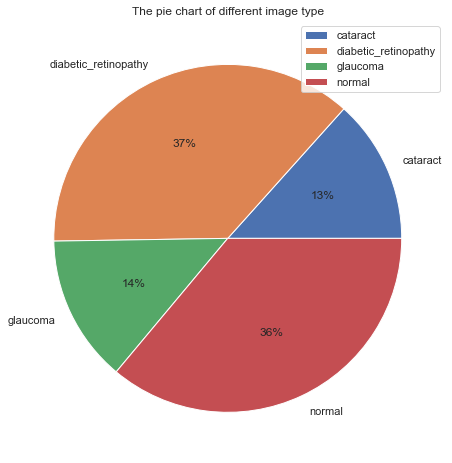

In [25]:
pandasdf.groupby(['type']).count().plot.pie(y='width', autopct='%1.0f%%', ylabel='',
                                            title = 'The pie chart of different image type',figsize=(8, 8))

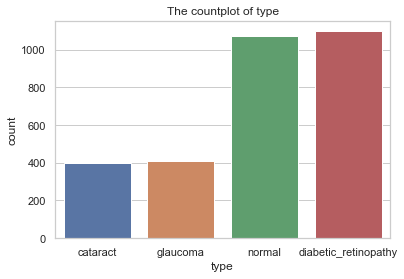

In [26]:
ax = sns.countplot(x=pandasdf.type).set(title='The countplot of type')
plt.show()

## The distribution of images' width

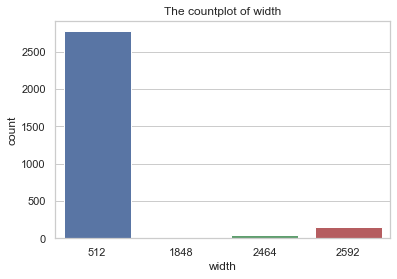

In [27]:
ax = sns.countplot(x=pandasdf.width).set(title='The countplot of width')
plt.show()

## The distribution of images' height

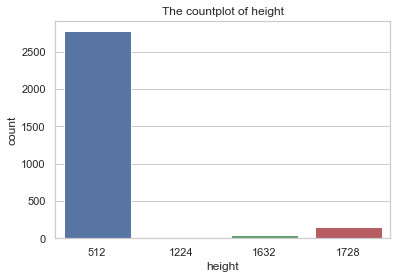

In [28]:
ax = sns.countplot(x=pandasdf.height).set(title='The countplot of height')
plt.show()

- Remove images that has invalid shap (the ratio is not equal to 1:1)

In [29]:
df = df.filter((df['image.height'] == 512) & (df['image.width'] == 512) ).cache()

In [30]:
df.count()

2776

## Feature Extraction

In [31]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import BinaryType, ArrayType, IntegerType
import numpy as np
from pyspark.ml.linalg import Vectors, VectorUDT

In [32]:
# pick a small sample as target
df = df.limit(10).cache()

### Grayscale image (transfer images from three layers to one layer)

In [33]:
def to_grayscale(image):
    img_obj = Image.frombytes('RGB', (image['width'], image['height']), bytes(image['data']))
    img_obj = ImageOps.grayscale(img_obj)
   # imgByteArr = io.BytesIO()
   # img_obj.save(imgByteArr, format=image.format)
    return bytearray(img_obj.tobytes())

In [34]:
grayscale_udf = udf(lambda x:to_grayscale(x), BinaryType())

In [35]:
df = df.withColumn("image.gray", grayscale_udf(df.image))

### Find edges

In [36]:
def find_edges(image):
    img_obj = Image.frombytes('RGB', (image['width'], image['height']), bytes(image['data']))
    img_obj =  img_obj.convert("L").filter(ImageFilter.FIND_EDGES)
    return bytearray(img_obj.tobytes())


In [37]:
edge_udf = udf(lambda x:find_edges(x), BinaryType())

In [38]:
df = df.withColumn("image.edge", edge_udf(df.image))

## Binarize Images

In [39]:
# Calulating an average 
def binarize(image):
    img_obj = Image.frombytes('RGB', (image['width'], image['height']), bytes(image['data']))
    img_obj = img_obj.convert("L")
    for x in range(512):
        for y in range(512):
            if img_obj.getpixel((x,y)) < 50:
                img_obj.putpixel((x,y),0)
            else:
                img_obj.putpixel((x,y),255)
    return bytearray(img_obj.tobytes())


In [40]:
bin_udf = udf(lambda x:binarize(x), BinaryType())

In [41]:
df = df.withColumn("image.bin", bin_udf(df.image))

In [42]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- type: string (nullable = false)
 |-- image.gray: binary (nullable = true)
 |-- image.edge: binary (nullable = true)
 |-- image.bin: binary (nullable = true)



compare orign image, gray image, and edge image

In [43]:
first_img = df.first()

In [44]:
first_img['type']

'normal'

- Original image

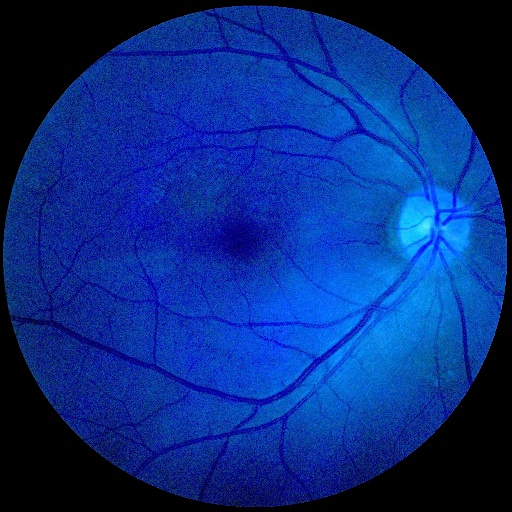

In [45]:
# imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# img = Image.fromarray(imageRGB)

# img.save('fromArray.jpg')

Image.frombytes('RGB', (512, 512), bytes(first_img['image']['data']))

- Grayscale Image

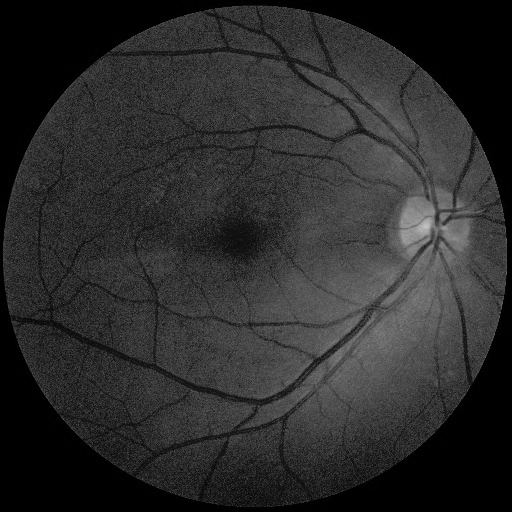

In [46]:
Image.frombytes('L', (512, 512), bytes(first_img['image.gray']))

- Images with only edges

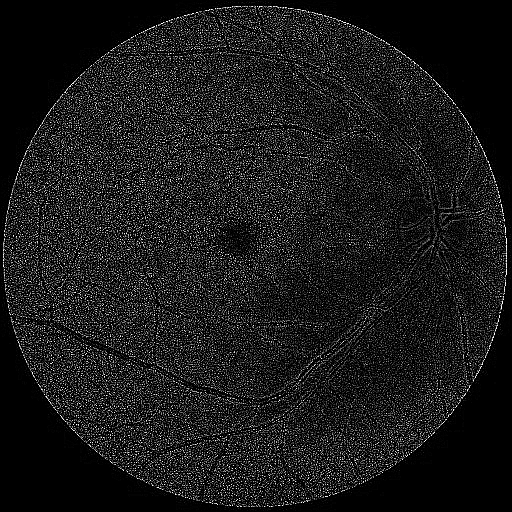

In [47]:
Image.frombytes('L', (512, 512), bytes(first_img['image.edge']))

- Binarized Image

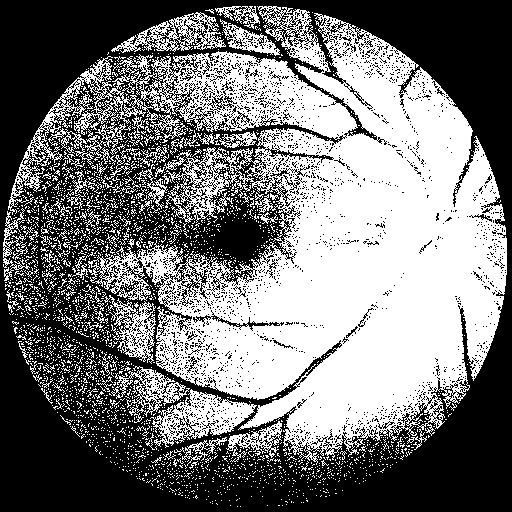

In [48]:
Image.frombytes('L', (512, 512), bytes(first_img['image.bin']))

## Models

In [49]:
!pip install sparkdl

In [51]:
!pip install keras

  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [53]:
!pip install tensorflow

  Using cached tensorflow-2.11.0-cp38-cp38-macosx_10_14_x86_64.whl (244.3 MB)


In [55]:
!pip install tensorframes

  Using cached tensorframes-0.2.9-py3-none-any.whl (10 kB)


In [57]:
!pip install keras

In [58]:
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer

ImportError: cannot import name 'resnet50' from 'keras.applications' (/Users/zhaoyudong/opt/anaconda3/lib/python3.8/site-packages/keras/applications/__init__.py)